In [1]:
import pandas as pd
import numpy as np 
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.nonparametric.smoothers_lowess import lowess
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

In [2]:
df_data = pd.read_csv("CrudeOil.csv")

Y	World Crude Oil Production
X1	U.S. Energy Consumption
X2	U.S. Nuclear Generation
X3	U.S. Coal Production
X4	U.S. Dry Gas Production
X5 	U.S. Fuel Rate for Autos


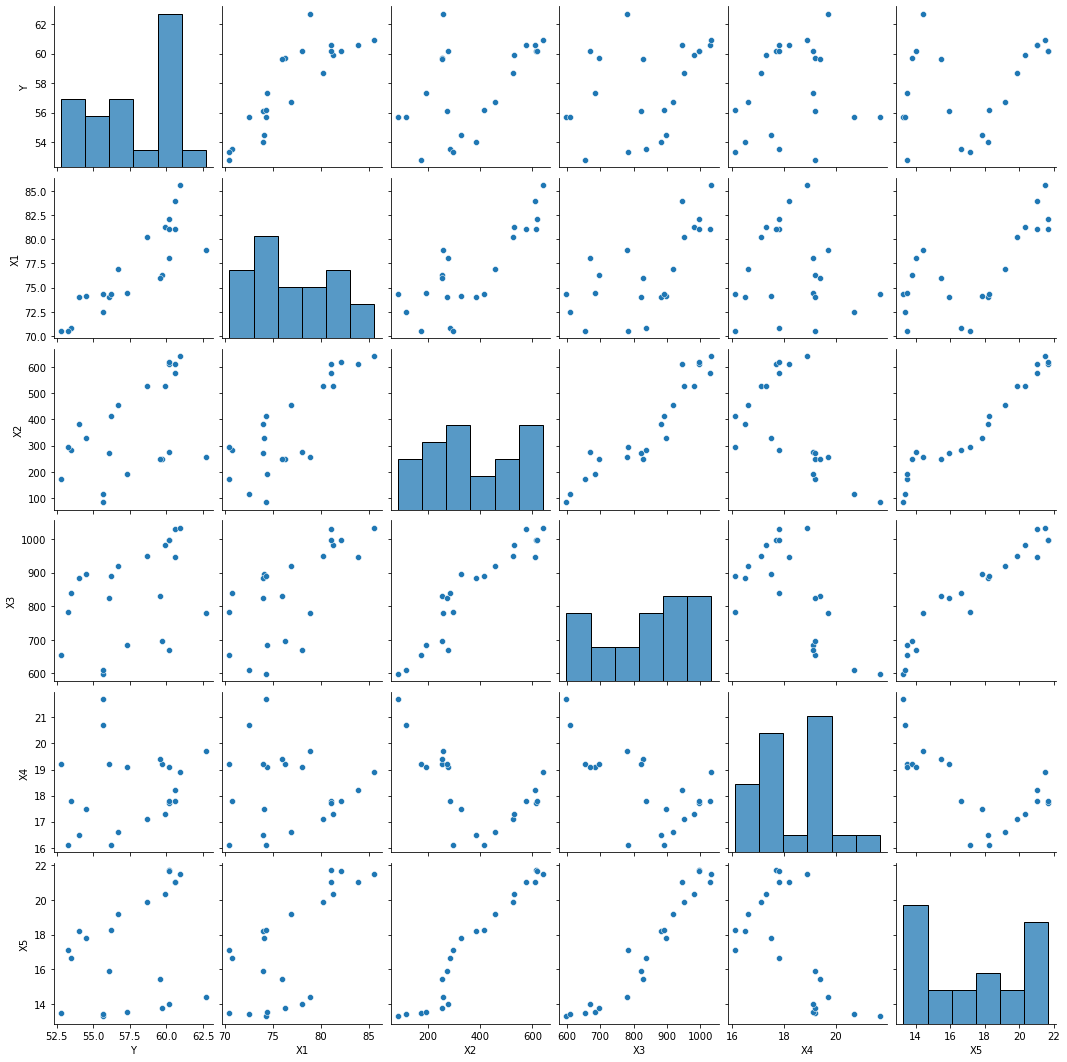

In [4]:
sns.pairplot(df_data)

In [5]:
df_data.corr(method = "pearson")

,Y,X1,X2,X3,X4,X5
Y,1.000000,0.861862,0.508893,0.390057,0.167691,0.343921
X1,0.861862,1.000000,0.808575,0.675801,-0.061540,0.693866
X2,0.508893,0.808575,1.000000,0.937456,-0.572352,0.968853
X3,0.390057,0.675801,0.937456,1.000000,-0.637790,0.959980
X4,0.167691,-0.061540,-0.572352,-0.637790,1.000000,-0.630681
X5,0.343921,0.693866,0.968853,0.959980,-0.630681,1.000000


In [6]:
df_data.corr(method = "spearman")

,Y,X1,X2,X3,X4,X5
Y,1.000000,0.916195,0.501698,0.486992,0.165060,0.473417
X1,0.916195,1.000000,0.695874,0.681176,-0.055556,0.669305
X2,0.501698,0.695874,1.000000,0.953698,-0.639300,0.987578
X3,0.486992,0.681176,0.953698,1.000000,-0.578145,0.966121
X4,0.165060,-0.055556,-0.639300,-0.578145,1.000000,-0.637602
X5,0.473417,0.669305,0.987578,0.966121,-0.637602,1.000000


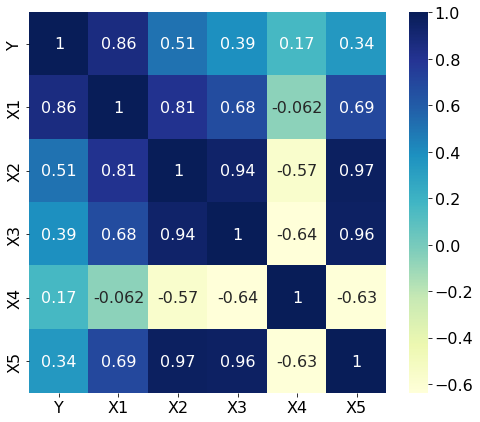

In [16]:
dataplot = sns.heatmap(df_data.corr(), cmap="YlGnBu", annot=True)
plt.show()

In [7]:
model = smf.ols(formula="Y ~ X1 +X2+X3+X4+X5", data=df_data)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                      Y   R-squared:                       0.903
Model:                            OLS   Adj. R-squared:                  0.873
Method:                 Least Squares   F-statistic:                     29.82
Date:                Wed, 02 Mar 2022   Prob (F-statistic):           1.44e-07
Time:                        16:42:35   Log-Likelihood:                -28.855
No. Observations:                  22   AIC:                             69.71
Df Residuals:                      16   BIC:                             76.26
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      6.6752     12.133      0.550      0.5

In [17]:
results.ssr

0.8021371613636362

In [8]:
anova_table = sm.stats.anova_lm(results, typ=2)
print(anova_table)

             sum_sq    df          F    PR(>F)
X1        20.083058   1.0  18.103956  0.000605
X2         0.008779   1.0   0.007914  0.930216
X3         4.027186   1.0   3.630323  0.074868
X4         0.535799   1.0   0.482998  0.497037
X5         6.561677   1.0   5.915051  0.027127
Residual  17.749100  16.0        NaN       NaN


Text(0, 0.5, 'Residuals')

Text(0.5, 0, 'Fitted Values')

Text(0.5, 1.0, 'Residuals vs. Fitted')

Text(62.76888402704206, -1.8688840270420641, '21')

Text(58.54314233284894, 1.6568576671510655, '18')

Text(55.268339464731355, -1.2683394647313548, '12')

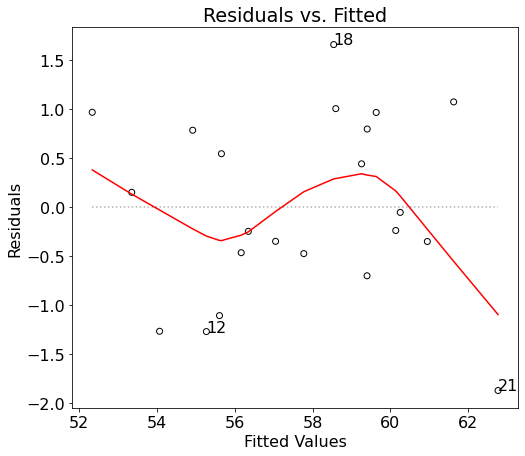

In [9]:
residuals = results.resid
fitted = results.fittedvalues
smoothed = lowess(residuals,fitted)
top3 = abs(residuals).sort_values(ascending = False)[:3]

plt.rcParams.update({'font.size': 16})
plt.rcParams["figure.figsize"] = (8,7)
fig, ax = plt.subplots()
ax.scatter(fitted, residuals, edgecolors = 'k', facecolors = 'none')
ax.plot(smoothed[:,0],smoothed[:,1],color = 'r')
ax.set_ylabel('Residuals')
ax.set_xlabel('Fitted Values')
ax.set_title('Residuals vs. Fitted')
ax.plot([min(fitted),max(fitted)],[0,0],color = 'k',linestyle = ':', alpha = .3)

for i in top3.index:
    ax.annotate(i,xy=(fitted[i],residuals[i]))

plt.show()

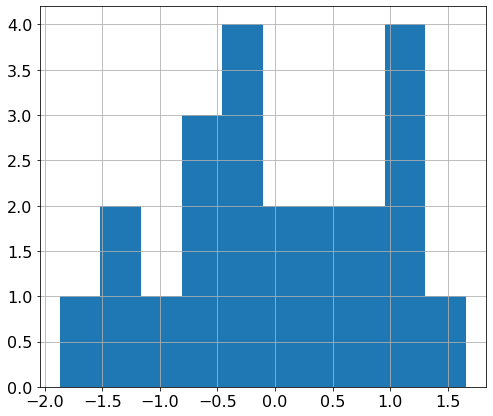

In [10]:
residuals.hist()

Text(0.5, 1.0, 'Normal Q-Q')

Text(0, 0.5, 'Standardized Residuals')

Text(0.5, 0, 'Theoretical Quantiles')

Text(-1.866073719864905, -2.1113411471576597, '21')

Text(1.866073719864905, 1.7907007395657637, '18')

Text(-1.4379145338982962, -1.5668192695422976, '2')

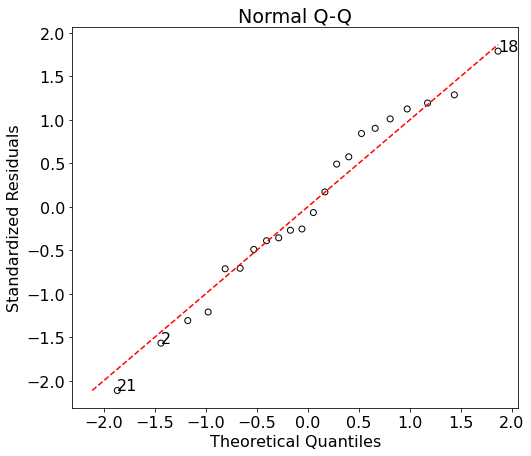

In [11]:
sorted_student_residuals = pd.Series(results.get_influence().resid_studentized_internal)
sorted_student_residuals.index = results.resid.index
sorted_student_residuals = sorted_student_residuals.sort_values(ascending = True)
df = pd.DataFrame(sorted_student_residuals)
df.columns = ['sorted_student_residuals']
df['theoretical_quantiles'] = stats.probplot(df['sorted_student_residuals'], dist = 'norm', fit = False)[0]
rankings = abs(df['sorted_student_residuals']).sort_values(ascending = False)
top3 = rankings[:3]

fig, ax = plt.subplots()
x = df['theoretical_quantiles']
y = df['sorted_student_residuals']
ax.scatter(x,y, edgecolor = 'k',facecolor = 'none')
ax.set_title('Normal Q-Q')
ax.set_ylabel('Standardized Residuals')
ax.set_xlabel('Theoretical Quantiles')
ax.plot([np.min([x,y]),np.max([x,y])],[np.min([x,y]),np.max([x,y])], color = 'r', ls = '--')
for val in top3.index:
    ax.annotate(val,xy=(df['theoretical_quantiles'].loc[val],df['sorted_student_residuals'].loc[val]))
plt.show()

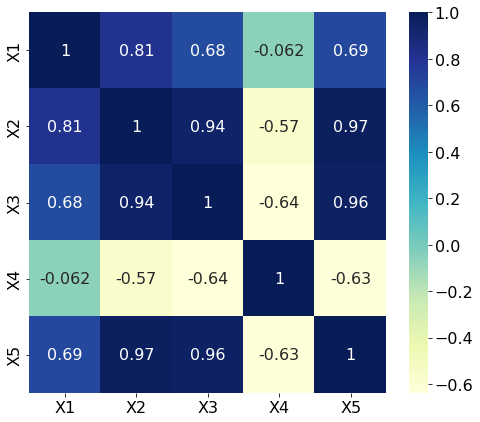

In [15]:
dataplot = sns.heatmap(df_data[["X1","X2", "X3", "X4", "X5"]].corr(), cmap="YlGnBu", annot=True)
plt.show()

In [18]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
# the independent variables set
X = df_data[['X1', 'X2', 'X3', "X4", "X5"]]
  
# VIF dataframe
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns
  
# calculating VIF for each feature
vif_data["VIF"] = [variance_inflation_factor(X.values, i)
                          for i in range(len(X.columns))]
  
print(vif_data)

  feature          VIF
0      X1  1439.977869
1      X2    73.824181
2      X3   537.815384
3      X4   770.922697
4      X5   685.865594


In [ ]:
## Eliminate features stepwise Regression and move forward